In [1]:
from my_krml_24886400.data.sets import get_data_from_gdrive, merge_dataframes_on_common_columns
import pandas as pd
import os
import matplotlib.pyplot as plt
import joblib

In [2]:
file_path = '../../data'
os.makedirs(file_path, exist_ok=True)

# load raw data files
df_train = get_data_from_gdrive(url='https://drive.google.com/file/d/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA/view', file_path=file_path)
df_items = get_data_from_gdrive('https://drive.google.com/file/d/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA/view', file_path)
df_cal = get_data_from_gdrive('https://drive.google.com/file/d/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM/view', file_path)
df_events = get_data_from_gdrive('https://drive.google.com/file/d/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4/view', file_path)

../../data/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA.csv already exists. Reading the file from the local directory.
../../data/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA.csv already exists. Reading the file from the local directory.
../../data/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM.csv already exists. Reading the file from the local directory.
../../data/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4.csv already exists. Reading the file from the local directory.


In [3]:
# Melt the train_df to have a long format
df_train = pd.melt(df_train,
         id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
         var_name='d',
         value_name='item_sold')

In [4]:
dataframe_list = [df_train, df_cal, df_events, df_items]

sales_data = merge_dataframes_on_common_columns(dataframe_list)
sales_data.shape

['d']
['date']
['wm_yr_wk', 'store_id', 'item_id']


(47107050, 13)

In [5]:
sales_data['sales_revenue'] = sales_data['item_sold'] * sales_data['sell_price']

In [6]:
# Convert 'date' to datetime if not already
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Aggregate sales_revenue by date
daily_sales = sales_data.groupby('date')['sales_revenue'].sum().reset_index()

# Sort by date
daily_sales.sort_values('date', inplace=True)

# Set 'date' as the index
daily_sales.set_index('date', inplace=True)

daily_sales.head()

,sales_revenue
date,
2011-01-29,81650.61
2011-01-30,78970.57
2011-01-31,57706.91
2011-02-01,60761.20
2011-02-02,46959.95


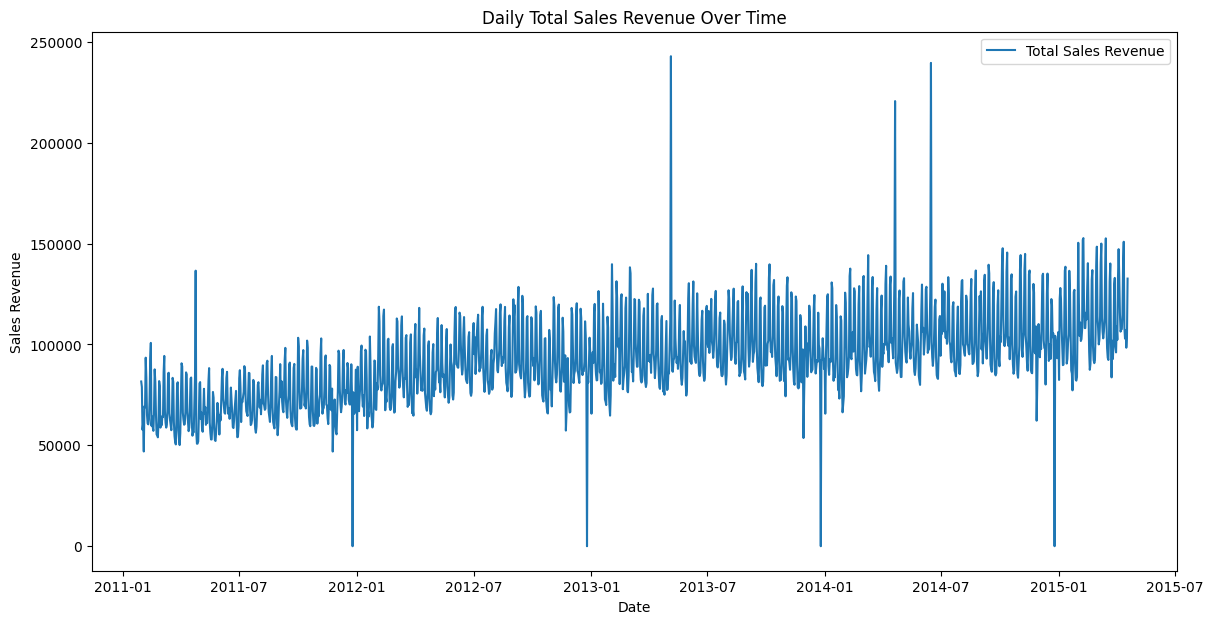

In [7]:
plt.figure(figsize=(14,7))
plt.plot(daily_sales.index, daily_sales['sales_revenue'], label='Total Sales Revenue')
plt.title('Daily Total Sales Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(daily_sales['sales_revenue'], title='Daily Sales Revenue')

Augmented Dickey-Fuller Test: Daily Sales Revenue
ADF Statistic: -1.8682476785531525
p-value: 0.34714261537651037
#Lags Used: 24
Number of Observations Used: 1516
=> The series is non-stationary.


In [9]:
# First-order differencing
daily_sales['sales_revenue_diff'] = daily_sales['sales_revenue'].diff()

# Drop NaN values
daily_sales_diff = daily_sales.dropna()

# ADF Test on differenced data
adf_test(daily_sales_diff['sales_revenue_diff'], title='Differenced Daily Sales Revenue')

Augmented Dickey-Fuller Test: Differenced Daily Sales Revenue
ADF Statistic: -14.763786320041914
p-value: 2.379872252353299e-27
#Lags Used: 24
Number of Observations Used: 1515
=> The series is stationary.


In [10]:
# Define forecast horizon
forecast_horizon = 7

# Split the data
train = daily_sales.iloc[:-forecast_horizon]
test = daily_sales.iloc[-forecast_horizon:]

print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")

Training data from 2011-01-29 00:00:00 to 2015-04-11 00:00:00
Testing data from 2015-04-12 00:00:00 to 2015-04-18 00:00:00


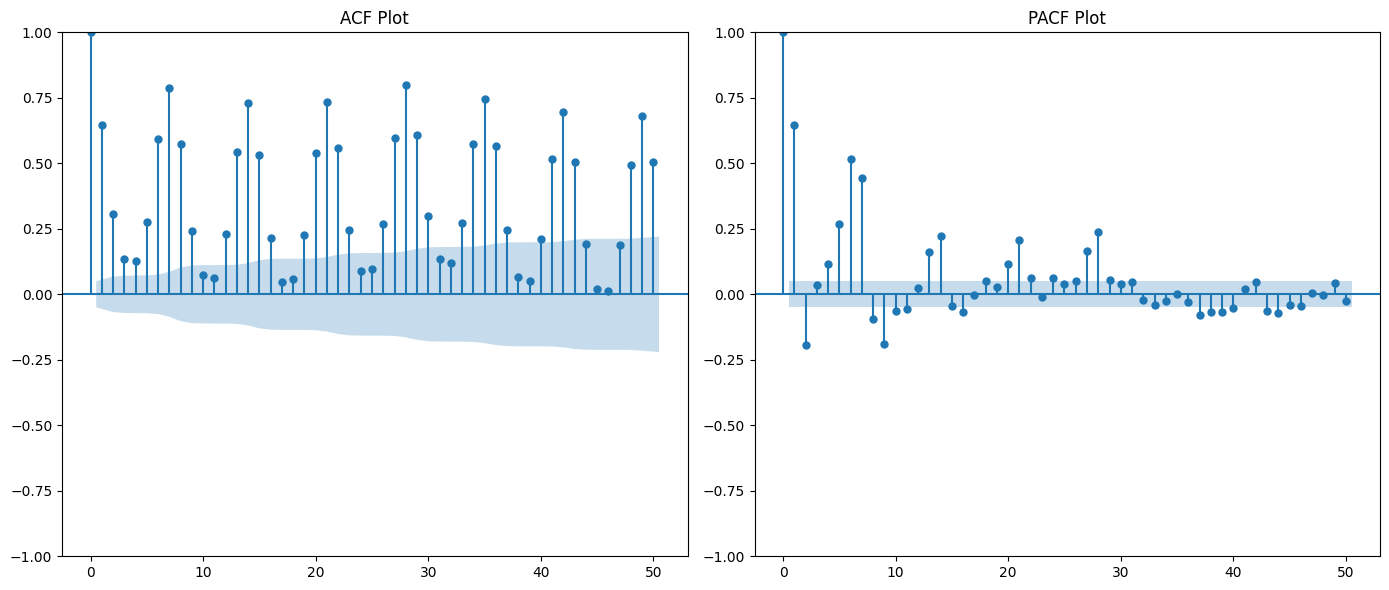

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plot_acf(train['sales_revenue'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1,2,2)
plot_pacf(train['sales_revenue'], lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model
model = SARIMAX(train['sales_revenue'], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit(disp=False)
print(model_fit.summary())

/Users/rusanvaidya/Library/Caches/pypoetry/virtualenvs/36120-at2-24886400--VV9Swk3-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rusanvaidya/Library/Caches/pypoetry/virtualenvs/36120-at2-24886400--VV9Swk3-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                     sales_revenue   No. Observations:                 1534
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -16336.344
Date:                           Tue, 08 Oct 2024   AIC                          32682.687
Time:                                   18:17:37   BIC                          32709.310
Sample:                               01-29-2011   HQIC                         32692.600
                                    - 04-11-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0237      0.040      0.593      0.553      -0.055       0.102
ma.L1         -0.6744      0.037    -18.132

In [13]:
# Forecast for the next 7 days
forecast = model_fit.get_forecast(steps=forecast_horizon)
forecast_ci = forecast.conf_int()

# Extract forecasted mean
forecast_values = forecast.predicted_mean

# Align forecast index with test index
forecast_series = pd.Series(forecast_values.values, index=test.index)

# Display forecasted values
print(forecast_series)

date
2015-04-12    144580.190753
2015-04-13    114617.737573
2015-04-14    105358.788716
2015-04-15    106671.709685
2015-04-16    103632.054436
2015-04-17    117525.147453
2015-04-18    143442.295740
dtype: float64


In [14]:
from sklearn.metrics import mean_squared_error

# Calculate metrics
rmse = mean_squared_error(test['sales_revenue'], forecast_series, squared=False)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 7927.046167499849


/Users/rusanvaidya/Library/Caches/pypoetry/virtualenvs/36120-at2-24886400--VV9Swk3-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


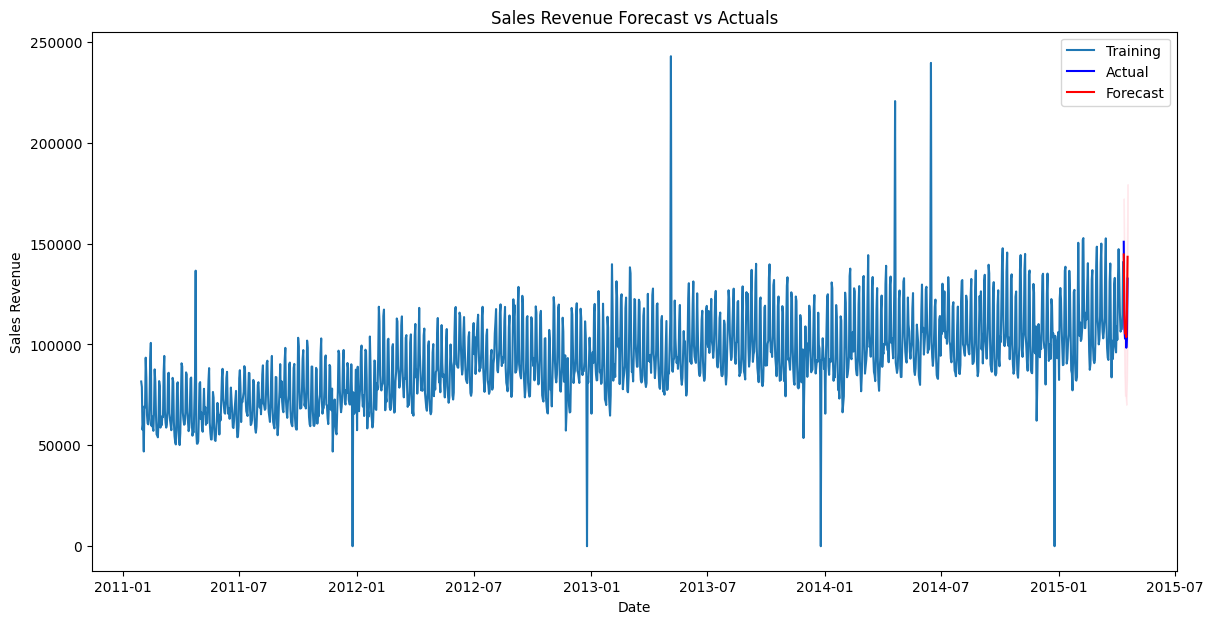

In [15]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train['sales_revenue'], label='Training')
plt.plot(test.index, test['sales_revenue'], label='Actual', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('Sales Revenue Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.show()

In [16]:
date_=input("ENTER DATE")
input_date = pd.to_datetime(date_)
# Align forecast index with test index
forecast_index = pd.date_range(start=input_date, periods=7)
forecast_series = pd.Series(forecast_values.values, index=forecast_index)

# Display forecasted values
print(f"Forecast for 7 days starting from {input_date}:\n", forecast_series)


ENTER DATE 23-12-2019


Forecast for 7 days starting from 2019-12-23 00:00:00:
 2019-12-23    144580.190753
2019-12-24    114617.737573
2019-12-25    105358.788716
2019-12-26    106671.709685
2019-12-27    103632.054436
2019-12-28    117525.147453
2019-12-29    143442.295740
Freq: D, dtype: float64


/var/folders/qz/l2xk6fnn5p399gdvg2snh00c0000gn/T/ipykernel_25997/280747218.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  input_date = pd.to_datetime(date_)


In [17]:
model_path="../../models/forecasting"
os.makedirs(model_path, exist_ok=True)
joblib.dump(model_fit, f"{model_path}/forecasting.joblib")
print(f"Model saved to {model_path}")

Model saved to ../../models/forecasting
